# Presentation images and videos
These images are used in the presentation

In [1]:
using Printf, LinearAlgebra
using JLD2
using CairoMakie
using MyTwoLayerNN

In [2]:
set_theme!() # Theme for plots 
update_theme!(Theme(fontsize = 27)) # 18 for testing and 36 for report

In [3]:
# Colors 
MYORANGE = Makie.RGB(213/255, 94/255, 0/255)
BACKGROUND_COLOR = Makie.RGB(238/255, 232/255, 232/255)

In [4]:
# Training data 
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

flatX = dataX |> Iterators.flatten |> collect

4-element Vector{Float64}:
 -0.5
 -0.16666666666666666
  0.16666666666666666
  0.5

## Movies

In [94]:
function mynumberformat(x)
    e = 0
    if x != 0.0
        e = floor(Int, log10(x))
    end

    leftover = x / (10.0 ^ e)
    return @sprintf "%.2fe%d" leftover e
end

mynumberformat (generic function with 1 method)

In [110]:
function my_movie(; nn::TwoLayerNN, learning_rate, 
                    xlim = nothing, ylim = nothing, total_epochs = 100_000, 
                    epochs_between_frames = 1000, framerate = 10, file_name="vid.mp4"
                )
    
    time = Observable(0.0)
    stringtime = lift(t -> "time = " * mynumberformat(t), time)

    # Create figure
    f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1))

    ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", xticks = -0.5:0.25:0.5, title = stringtime, backgroundcolor = (BACKGROUND_COLOR, 1))

    # Draw NN graph
    xgrid = range(-0.5, 0.5, length = 100)
    yobs = Observable([forward(nn, x) for x in xgrid])
    lines!(ax, xgrid, yobs; color=MYORANGE, linewidth=4)

    # Scatter data points
    scatter!(ax, flatX, dataY; markersize = 24)

    colsize!(f.layout, 1, Aspect(1, 4/3))

    # Movie parameters
    timestamps = range(0, total_epochs / (epochs_between_frames * framerate), step=1/framerate)

    # Training data
    training_data = TrainingData(dataX, dataY, learning_rate, epochs_between_frames)

    # Create video
    record(f, file_name, timestamps; framerate = framerate) do t
        # Train NN from t > 0
        !iszero(t) && train!(nn, training_data; stop_tol = false)

        yobs[] = [forward(nn, x) for x in xgrid]
        time[] = t * framerate * epochs_between_frames * learning_rate
    end
end

my_movie (generic function with 1 method)

In [111]:
# Entire training process
my_movie(
    nn = TwoLayerNN(1, 1000, 1.5, -0.5),
    learning_rate = 3000.0,
    total_epochs = 220_000,
    epochs_between_frames = 300,
    framerate = 30,
    file_name = "test.mp4"
)

"test.mp4"

In [117]:
# First two phases 
my_movie(
    nn = TwoLayerNN(1, 1000, 1.5, -0.5),
    learning_rate = 500.0,
    total_epochs = 36_000,
    epochs_between_frames = 300,
    framerate = 30,
    file_name = "beginning.mp4"
)

"beginning.mp4"

## ReLU

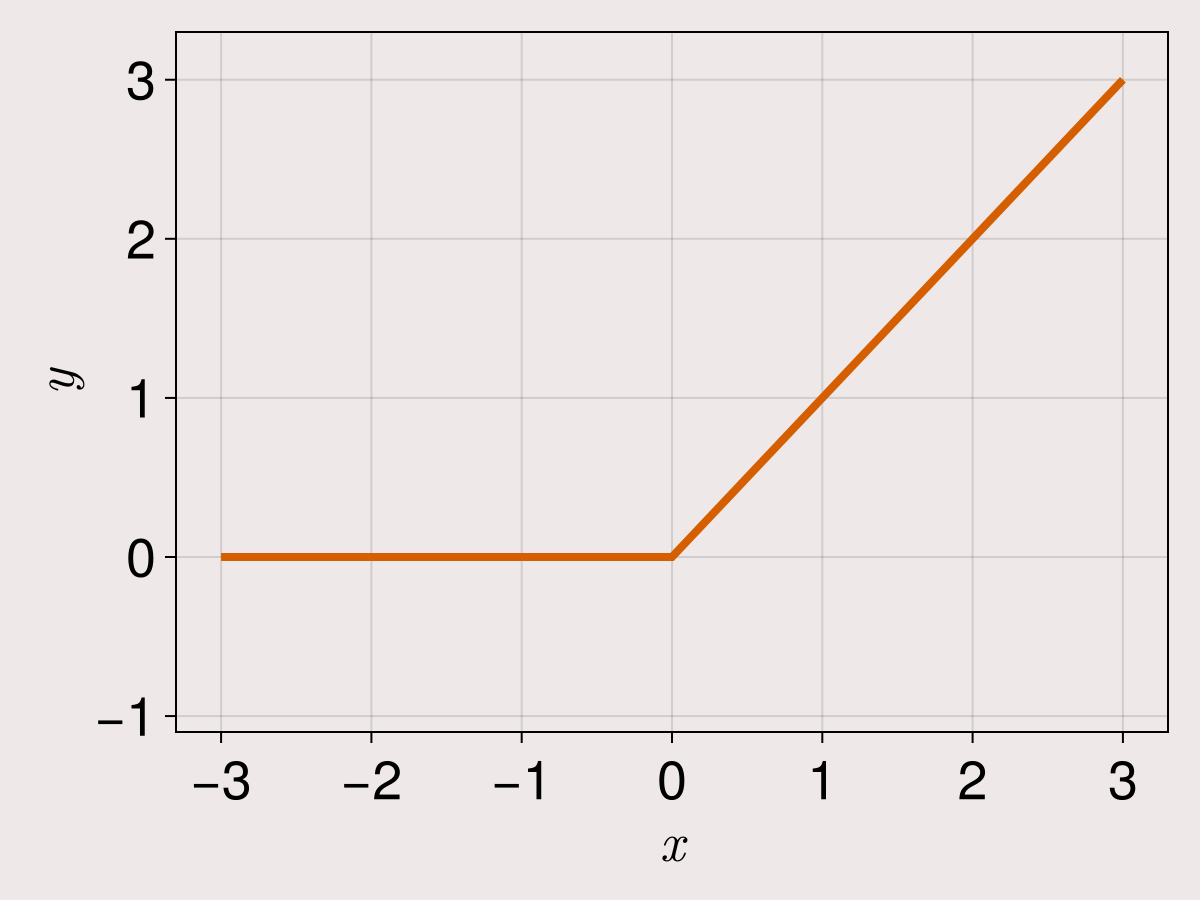

In [14]:
f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1)) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", xticks = -3:1:3, backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = range(-3, 3, length = 3)
ygrid = xgrid .|> x -> max(zero(x), x)

lines!(ax, xgrid, ygrid; color=MYORANGE, linewidth=4)

ylims!(ax, -1.1, 3.3)

colsize!(f.layout, 1, Relative(1))

f

In [15]:
save("relu.png", f)

CairoMakie.Screen{IMAGE}


In [380]:
# https://discourse.julialang.org/t/arrows-on-axis-in-makie/79015/2
function axisarrows!(ax::Axis=current_axis(); labels=true, kwargs...)
    points = @lift [
        $(ax.xaxis.attributes[:endpoints])[2],
        $(ax.yaxis.attributes[:endpoints])[2],
    ]
    directions = [Vec2f(1, 0), Vec2f(0, 1)]
    arrows!(ax.parent.scene, points, directions; kwargs...)
    
    labels && text!(ax.parent.scene, points[] + [[10, -11.5], [-8.5, 10]], text=[L"x", L"y"])
end

axisarrows! (generic function with 2 methods)

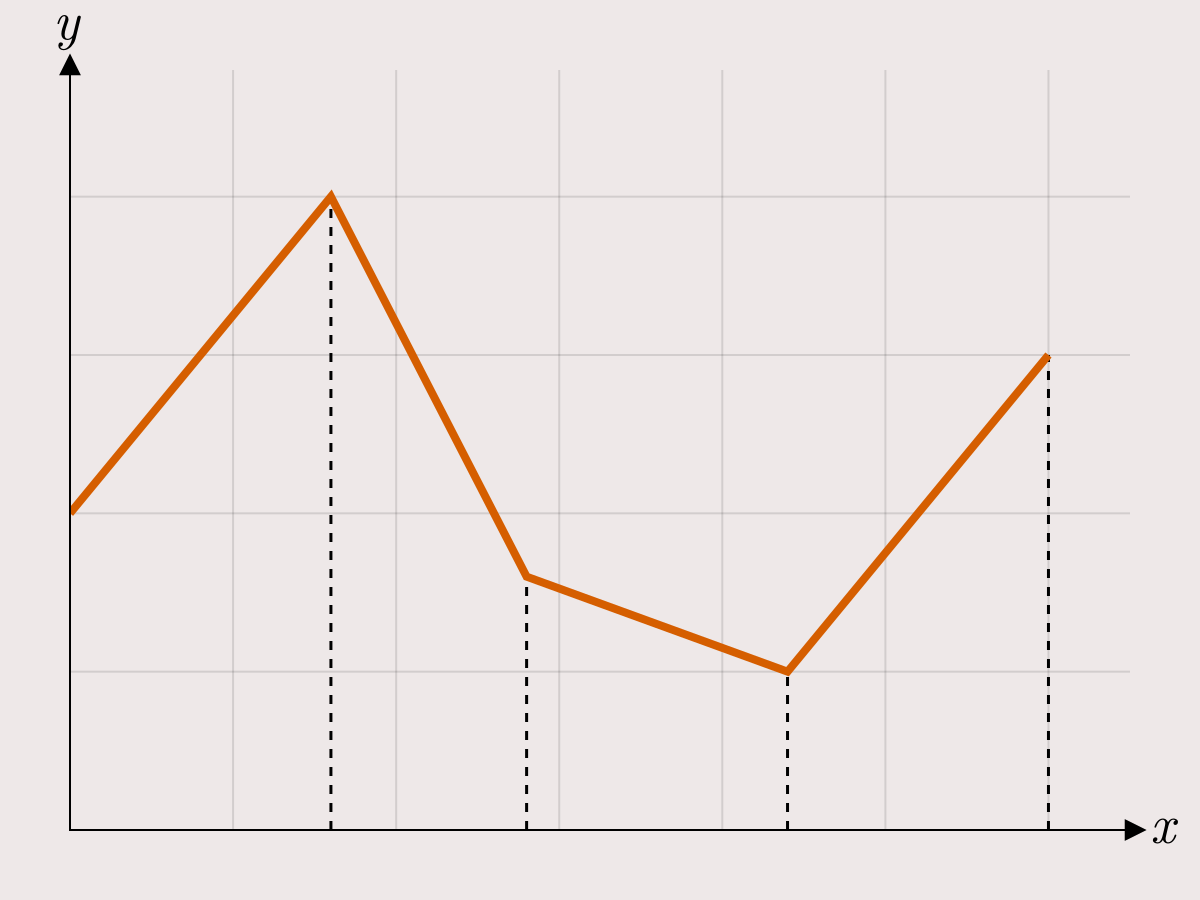

In [342]:
f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1), figure_padding = 35) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = [0.0, 1.6, 2.8, 4.4, 6.0]
ygrid = [1.0, 2.0, 0.8, 0.5, 1.5]

vlines!(ax, xgrid[2:end]; ymax=ygrid[2:end]/2.4, linestyle=:dash, color=:black)

lines!(ax, xgrid, ygrid; color=MYORANGE, linewidth=4)

xlims!(ax, 0.0, 6.5)
ylims!(ax, 0, 2.4)

hidedecorations!(ax, grid = false)
hidespines!(ax, :t, :r)
# hidespines!(ax)
axisarrows!(ax, arrowsize=15)


# colsize!(f.layout, 1, Relative(1))
# resize_to_layout!(f)

f

In [333]:
save("piecewise.png", f)

CairoMakie.Screen{IMAGE}


## Function approximation

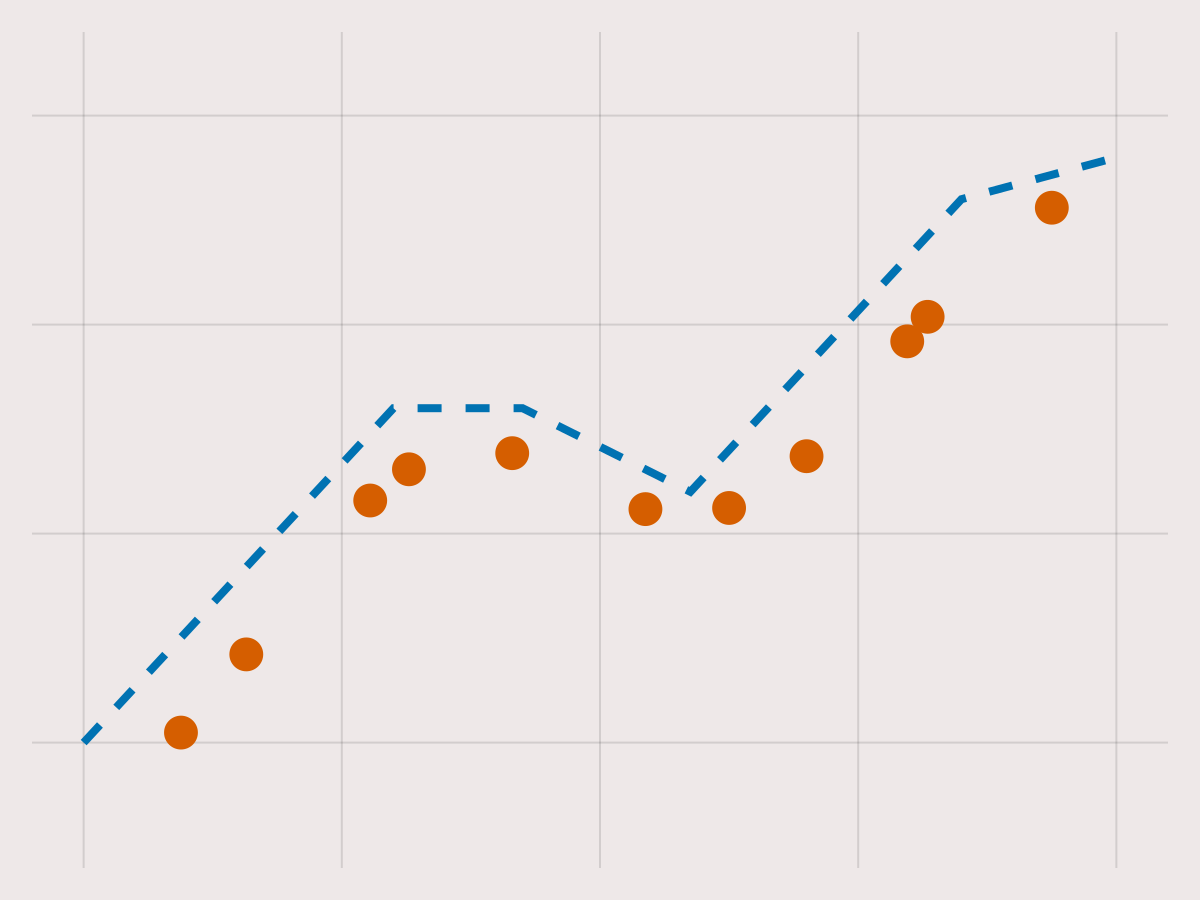

In [26]:
f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1)) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", yticks=0.25:0.25:1.0, backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = range(-2, 2, length = 100)
# ygrid = xgrid .|> x -> 0.2x^3 + cos(3x)/8 + tan(x/3) - 0.7x

myfunc(x) = exp(-(x-2)^2/2.5) + 0.5exp(-(x+0.6)^2) - 0.05x
yreal = xgrid .|> myfunc
# ypred = xgrid .|> x -> myfunc(x) + 0.1 + sin(5x)/20
# ypred = xgrid .|> x -> myfunc(x) + 0.1 + sin(8x)/20
ypred = xgrid .|> x -> myfunc(x) + 0.1 + sin(x)/20 + sin(x+2-3π/2)/20

# lines!(ax, xgrid, yreal; color = MYORANGE, linewidth = 4)
# lines!(ax, xgrid, ypred; linestyle = :dash, linewidth = 4)

# Blue piecewise affine function
lines!(ax, [-2, -0.8, -0.3, 0.35, 1.4, 2], [0.25, 0.65, 0.65, 0.55, 0.9, 0.95]; linestyle = :dash, linewidth = 4)

# Orange scatter points
xscatter = [-1.623, -1.37, -0.890, -0.74, -0.34, 0.176, 0.5, 0.8, 1.19, 1.269, 1.750]
# xscatter = [-1.623, -1.37, -0.6, 0.24, 1.19, 1.750]
yscatter = xscatter .|> myfunc
scatter!(ax, xscatter, yscatter; color = MYORANGE, markersize = 24)

ylims!(ax, 0.1, 1.1)
hidedecorations!(ax, grid = false)
hidespines!(ax)

colsize!(f.layout, 1, Relative(1))

f

In [27]:
save("function_approximation_4.png", f)

CairoMakie.Screen{IMAGE}


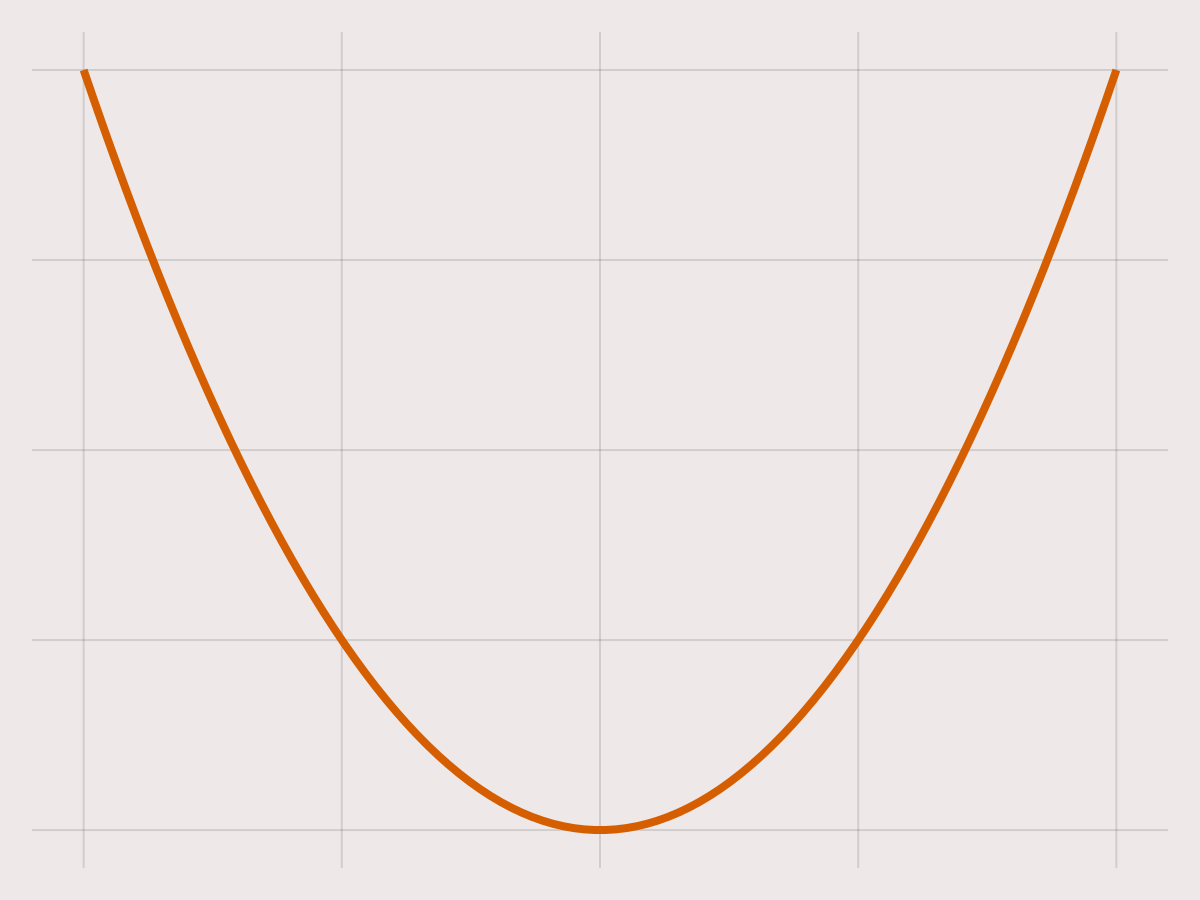

In [31]:
f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1)) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = range(-2, 2, length = 100)

myfunc(x) = x^2
yreal = xgrid .|> myfunc

lines!(ax, xgrid, yreal; color = MYORANGE, linewidth = 4)

# ylims!(ax, 0.1, 1.1)
hidedecorations!(ax, grid = false)
hidespines!(ax)

colsize!(f.layout, 1, Relative(1))

f

In [32]:
save("parabola.png", f)

CairoMakie.Screen{IMAGE}


## Phase diagram

In [196]:
DATAFODLER = "C:\\Users\\20212202\\Documents\\BEP\\Julia code - Github\\data\\phase diagram"

data = let
    γ = 0.5
    γ′ = 0.0
    load(joinpath(DATAFODLER, "run g=$γ gp=$γ′.jld2"))
end

Dict{String, Any} with 3 entries:
  "trainedNN"    => TwoLayerNN{Float64, typeof(_ReLu), typeof(_∂ReLu)}([0.80828…
  "trainingData" => TrainingData{Float64, Int64}([[-0.5], [-0.166667], [0.16666…
  "initNN"       => TwoLayerNN{Float64, typeof(_ReLu), typeof(_∂ReLu)}([0.80828…

In [197]:
nn = data["trainedNN"]
td = data["trainingData"]
inn = data["initNN"]

TwoLayerNN{Float64, typeof(MyTwoLayerNN._ReLu), typeof(MyTwoLayerNN._∂ReLu)}([0.8082879284649668; -1.1220725081141734; … ; -1.2505328746000024; -0.3463702447057351;;], [0.5982120032908713, -1.007534061728092, 1.9792329994168751, -0.3462198319016904, 1.2558982403338985, 0.03564654313687362, 0.8490240807518936, 0.9231296807572588, 0.9736674482047619, -0.3609524852394146  …  0.9232978930945667, -1.009848838189752, -0.022565232616764856, 0.6291710834882279, -0.09384507043038878, 0.03769774783468822, -1.55726472082453, -0.8471527767690751, -1.655290816517417, -1.8848309241990657], [-1.2778929042682445, 1.3458458389777976, 0.5349715054489175, 1.7445216472908298, -0.94562442319331, -0.257833652705556, 1.0155900103675077, -0.9748654504001906, -0.5250116933467154, 1.3515697216872853  …  0.03839914442190294, -0.4111467572130697, -0.25802506459434893, -0.4435302225201445, -0.12243304520494255, 0.1320432249518399, -0.1891516619677945, 0.9918812907173121, 0.13715215788415805, 1.7066316447372152], 3

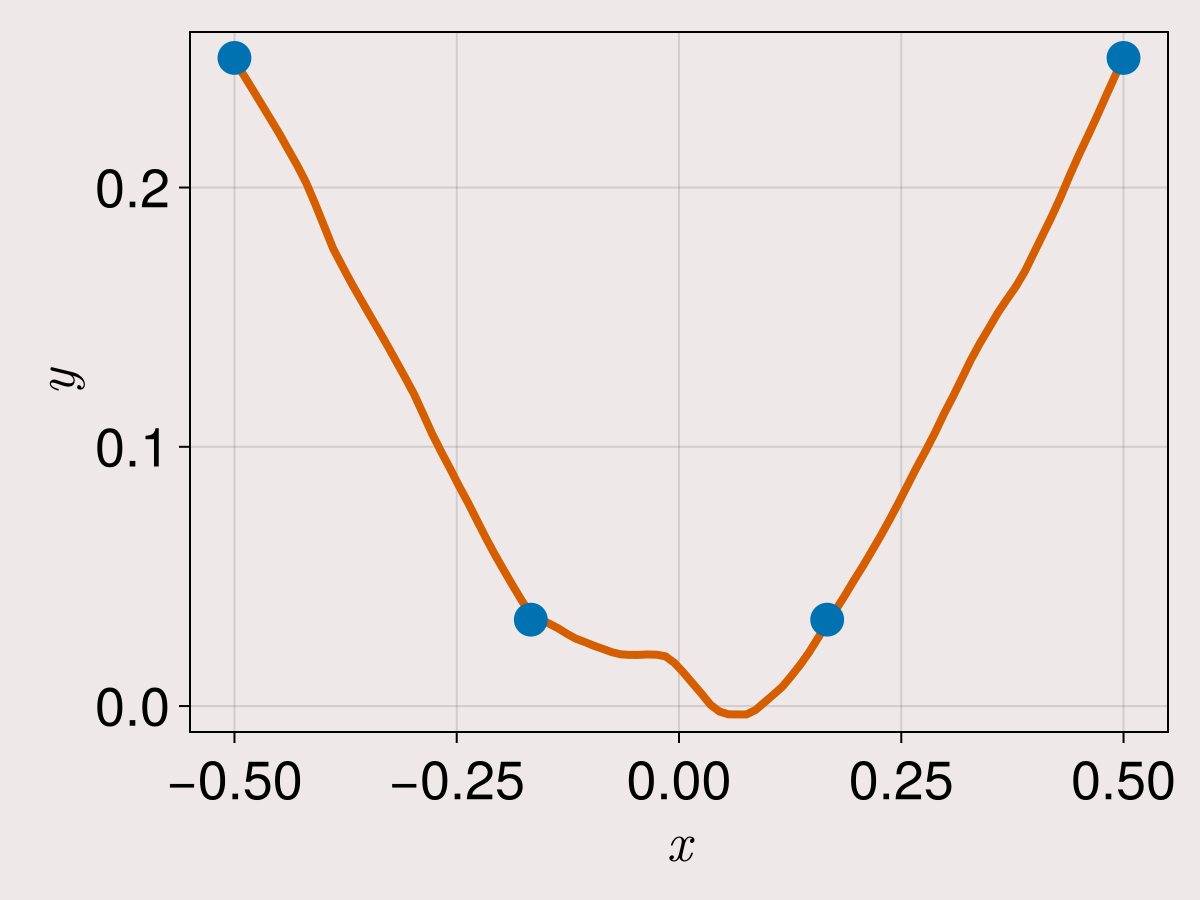

In [198]:
f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1)) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", xticks = -0.5:0.25:0.5, yticks=0.0:0.1:0.2, backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = range(-0.5, 0.5, length = 100)
ygrid = xgrid .|> x -> forward(nn, x)

lines!(ax, xgrid, ygrid; color=MYORANGE, linewidth=4)
scatter!(ax, flatX, dataY; markersize = 24)

ylims!(ax, -0.01, 0.26)

colsize!(f.layout, 1, Relative(1))

f

In [199]:
save("phase 05 00.png", f)

CairoMakie.Screen{IMAGE}


## Min and max over time

In [343]:
DATAFODLER = "C:\\Users\\20212202\\Documents\\BEP\\Julia code - Github\\data\\training"

"C:\\Users\\20212202\\Documents\\BEP\\Julia code - Github\\data\\training"

In [346]:
data = load(joinpath(DATAFODLER, "logarithmic.jld2"))
t_data = data["t_data"]
nn_data = data["nn_data"]
training_data = data["training_data"]

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 4000.0, 500000)

In [347]:
# Extract training data
xflat = training_data.x |> Iterators.flatten |> collect
xmin, xmax = training_data.x |> Iterators.flatten |> extrema
xvals = range(xmin, xmax, length=100)

-0.5:0.010101010101010102:0.5

In [348]:
xgrid = range(-0.5, 0.5, length = 100)
minvals = [minimum([forward(nn, p) for p in xgrid]) for nn in nn_data]
maxvals = [maximum([forward(nn, p) for p in xgrid]) for nn in nn_data];

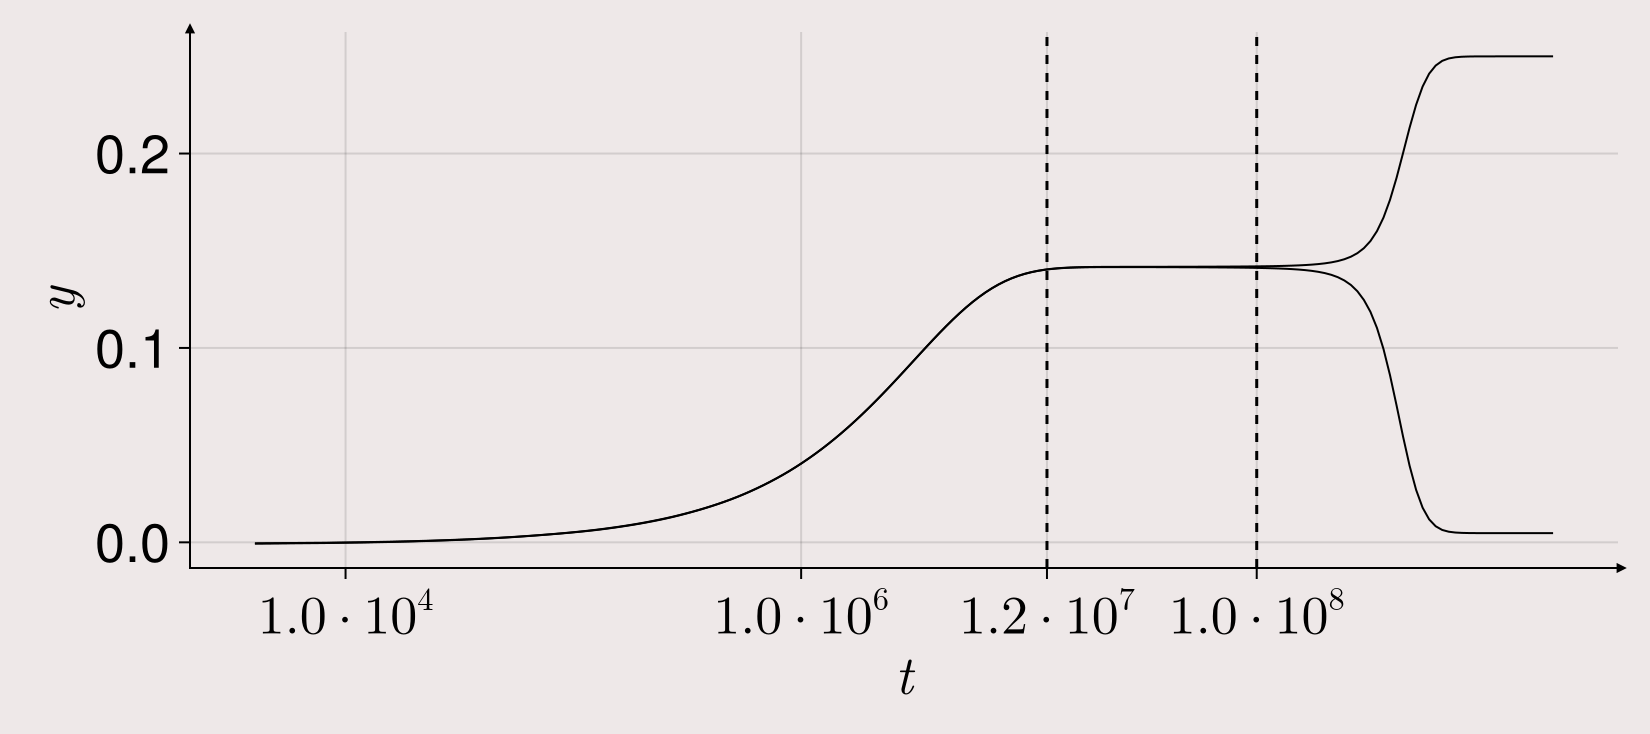

In [382]:
g = Figure(backgroundcolor = (BACKGROUND_COLOR, 1)) # 1cm = 44.625pt apperently for me

ax = Axis(g[1, 1], width = 2*8*44.625, height = 2*3*44.625, xlabel = L"t", ylabel = L"y", xscale = log10, xticks = ([1e4, 1e6, 1.2e7, 1e8], [L"1.0 \cdot 10^4", L"1.0 \cdot 10^6", L"1.2 \cdot 10^7", L"1.0 \cdot 10^8"]), backgroundcolor = (BACKGROUND_COLOR, 1))

lines!(ax, t_data, minvals; color=:black, linewidth=1)
lines!(ax, t_data, maxvals; color=:black, linewidth=1)

vlines!(ax, [1.2e7, 1e8]; linestyle=:dash, color=:black)

hidespines!(ax, :t, :r)
axisarrows!(ax, labels=false, arrowsize=7)
resize_to_layout!(g)

g

In [383]:
save("logarithmic.png", g)

CairoMakie.Screen{IMAGE}


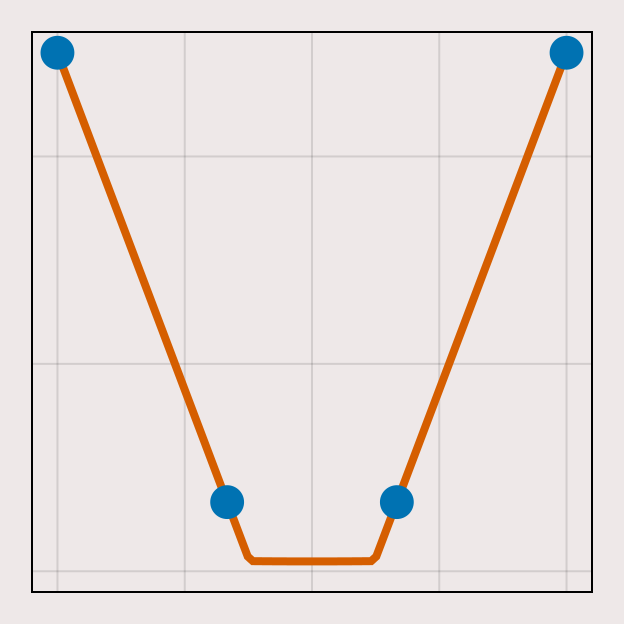

In [386]:
# nn = nn_data[findfirst(x -> x >= 3.6e8, t_data)]
nn = nn_data[end]

f = Figure(size=(7, 7) .* 44.625, backgroundcolor = (BACKGROUND_COLOR, 1)) 

ax = Axis(f[1, 1], xlabel = L"x", ylabel = L"y", xticks = -0.5:0.25:0.5, yticks=0.0:0.1:0.2, backgroundcolor = (BACKGROUND_COLOR, 1))

xgrid = range(-0.5, 0.5, length = 100)
ygrid = xgrid .|> x -> forward(nn, x)

lines!(ax, xgrid, ygrid; color=MYORANGE, linewidth=4)
scatter!(ax, flatX, dataY; markersize = 24)

ylims!(ax, -0.01, 0.26)

hidedecorations!(ax, grid = false)

colsize!(f.layout, 1, Relative(1))
resize_to_layout!(f)

f

In [387]:
save("line tend.png", f)

CairoMakie.Screen{IMAGE}


## Neural network trajectories

In [388]:
DATAFODLER = "C:\\Users\\20212202\\Documents\\BEP\\Julia code - Github\\data\\training"

data = load(joinpath(DATAFODLER, "a-lag begin symmetric.jld2"))
t_data = data["t_data"]
nn_data = data["nn_data"]
training_data = data["training_data"]

# Extract training data
xflat = training_data.x |> Iterators.flatten |> collect
xmin, xmax = training_data.x |> Iterators.flatten |> extrema
xvals = range(xmin, xmax, length=100)

-0.5:0.010101010101010102:0.5

In [389]:
function color_of_zone(zone)
    zone == 0 && return :gray 
    zone == 1 && return :purple
    zone == 2 && return :blue
    zone == 3 && return :green
    zone == 4 && return MYORANGE
end

function zone_neuron(w, b)
    sum(x -> (b > -w * x), xflat) |> color_of_zone
end

zone_neuron (generic function with 1 method)

In [397]:
mask = nn_data[1].a .> 0 .&& zone_neuron.(vec(nn_data[1].w), nn_data[1].b) .== :purple

w_data_pos_a = [nn.w[mask] for nn in nn_data] |> stack
b_data_pos_a = [nn.b[mask] for nn in nn_data] |> stack;

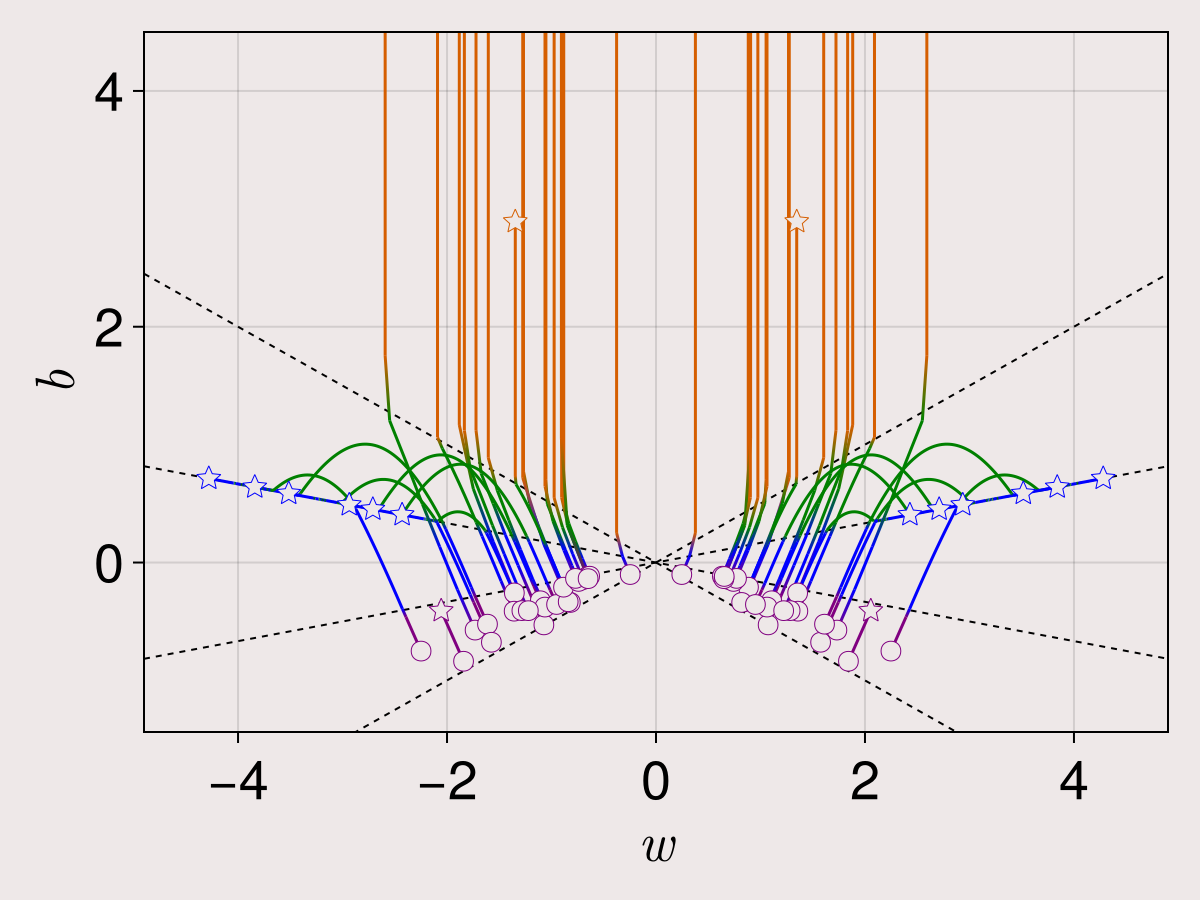

In [399]:
LINEWIDTH_ZONE = 1.0
LINEWIFTH_TRAJ = 1.5
SCATTER_SIZE = 14.0
SCATTER_STROKE = 0.5

f = Figure(backgroundcolor = (BACKGROUND_COLOR, 1))
ax = Axis(f[1, 1], xlabel=L"w", ylabel=L"b", xticks=-4:2:4, backgroundcolor = (BACKGROUND_COLOR, 1))

# Zone boundaries
ablines!(ax, 0, 1/2; linestyle=:dash, color=:black, linewidth=LINEWIDTH_ZONE)
ablines!(ax, 0, 1/6; linestyle=:dash, color=:black, linewidth=LINEWIDTH_ZONE)
ablines!(ax, 0, -1/6; linestyle=:dash, color=:black, linewidth=LINEWIDTH_ZONE)
ablines!(ax, 0, -1/2; linestyle=:dash, color=:black, linewidth=LINEWIDTH_ZONE)

# Neuron trajactories
for i in 1:size(w_data_pos_a, 1)
    lines!(ax, w_data_pos_a[i, :], b_data_pos_a[i, :]; color=zone_neuron.(w_data_pos_a[i, :], b_data_pos_a[i, :]), linewidth=LINEWIFTH_TRAJ) 
end

# Initial positions
scatter!(ax, w_data_pos_a[:, 1], b_data_pos_a[:, 1]; color=BACKGROUND_COLOR, markersize=SCATTER_SIZE, strokewidth=SCATTER_STROKE, strokecolor=zone_neuron.(w_data_pos_a[:, 1], b_data_pos_a[:, 1]))

# End points
scatter!(ax, w_data_pos_a[:, end], b_data_pos_a[:, end]; marker=:star5, color=BACKGROUND_COLOR, markersize=SCATTER_SIZE, strokewidth=SCATTER_STROKE, strokecolor=zone_neuron.(w_data_pos_a[:, end], b_data_pos_a[:, end]))

xlims!(ax, -4.9, 4.9)
ylims!(ax, -0.9375 - 0.5, 5 - 0.5)

f

In [400]:
save("trajactories.png", f)

CairoMakie.Screen{IMAGE}
